In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load and normalize MNIST
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X[:1200] / 255.0
y = y[:1200]

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y).astype(np.int64)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=42)


In [2]:
class Dense:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * 0.1
        self.b = np.zeros(out_dim)

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad, lr):
        dW = self.x.T @ grad
        db = np.sum(grad, axis=0)
        dx = grad @ self.W.T
        self.W -= lr * dW
        self.b -= lr * db
        return dx


In [3]:
class ReLU:
    def forward(self, x):
        self.mask = x > 0
        return x * self.mask

    def backward(self, grad, lr):
        return grad * self.mask


In [4]:
class SoftmaxCrossEntropy:
    def forward(self, x, y):
        self.y = y
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.probs = exps / np.sum(exps, axis=1, keepdims=True)
        log_likelihood = -np.log(self.probs[np.arange(len(y)), y] + 1e-9)
        return np.mean(log_likelihood)

    def backward(self, _, lr):
        grad = self.probs
        grad[np.arange(len(self.y)), self.y] -= 1
        return grad / len(self.y)


In [5]:
class MLP:
    def __init__(self):
        self.dense1 = Dense(784, 256)
        self.relu1 = ReLU()
        self.dense2 = Dense(256, 128)
        self.relu2 = ReLU()
        self.dense3 = Dense(128, 10)
        self.loss_fn = SoftmaxCrossEntropy()

    def forward(self, x, y):
        out = self.dense1.forward(x)
        out = self.relu1.forward(out)
        out = self.dense2.forward(out)
        out = self.relu2.forward(out)
        out = self.dense3.forward(out)
        loss = self.loss_fn.forward(out, y)
        self.out = out
        return out, loss

    def backward(self, lr):
        grad = self.loss_fn.backward(None, lr)
        grad = self.dense3.backward(grad, lr)
        grad = self.relu2.backward(grad, lr)
        grad = self.dense2.backward(grad, lr)
        grad = self.relu1.backward(grad, lr)
        grad = self.dense1.backward(grad, lr)

    def predict(self, x):
        out = self.dense1.forward(x)
        out = self.relu1.forward(out)
        out = self.dense2.forward(out)
        out = self.relu2.forward(out)
        out = self.dense3.forward(out)
        return np.argmax(out, axis=1)


In [6]:
model = MLP()
epochs = 10
batch_size = 20
lr = 0.01

train_losses, train_accuracies, test_accuracies = [], [], []

for epoch in range(epochs):
    perm = np.random.permutation(len(X_train))
    X_train = X_train[perm]
    y_train = y_train[perm]
    total_loss = 0
    correct = 0

    for i in range(0, len(X_train), batch_size):
        xb = X_train[i:i+batch_size]
        yb = y_train[i:i+batch_size]
        logits, loss = model.forward(xb, yb)
        pred = np.argmax(logits, axis=1)
        correct += np.sum(pred == yb)
        total_loss += loss
        model.backward(lr)

    acc = correct / len(X_train)
    test_preds = model.predict(X_test)
    test_acc = np.mean(test_preds == y_test)

    train_losses.append(total_loss)
    train_accuracies.append(acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Train Acc={acc:.4f}, Test Acc={test_acc:.4f}")


Epoch 1: Loss=101.8091, Train Acc=0.3030, Test Acc=0.6050
Epoch 2: Loss=73.9334, Train Acc=0.6230, Test Acc=0.7500
Epoch 3: Loss=56.1829, Train Acc=0.7330, Test Acc=0.8100
Epoch 4: Loss=44.8525, Train Acc=0.7890, Test Acc=0.8350
Epoch 5: Loss=37.5362, Train Acc=0.8200, Test Acc=0.8400
Epoch 6: Loss=32.4911, Train Acc=0.8360, Test Acc=0.8550
Epoch 7: Loss=28.9080, Train Acc=0.8580, Test Acc=0.8500
Epoch 8: Loss=26.1617, Train Acc=0.8700, Test Acc=0.8800
Epoch 9: Loss=24.0173, Train Acc=0.8740, Test Acc=0.8800
Epoch 10: Loss=21.9928, Train Acc=0.8920, Test Acc=0.8800


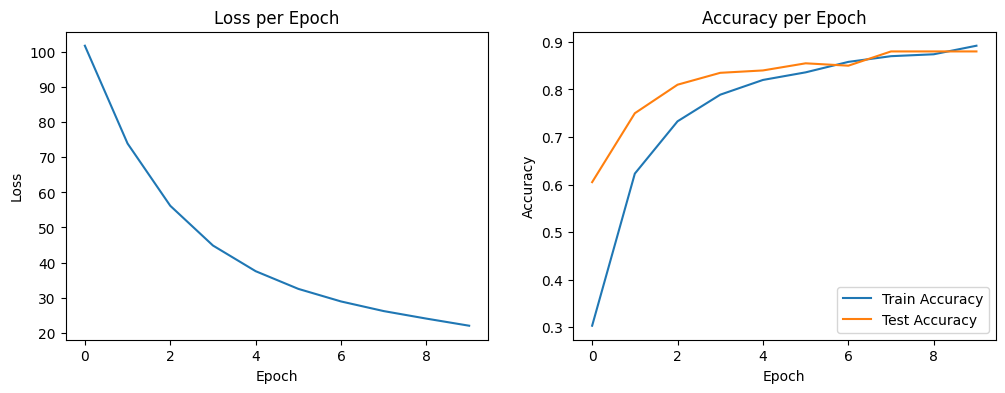

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


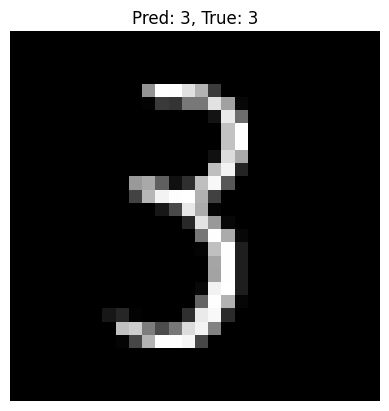

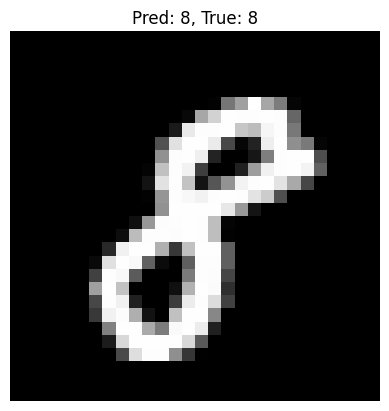

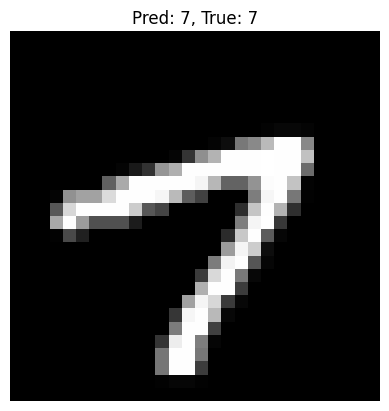

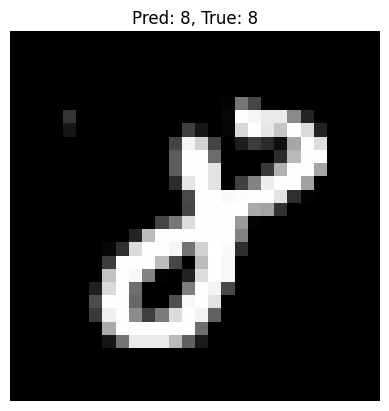

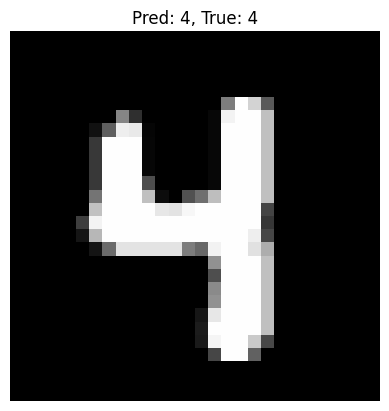

In [8]:
def show_predictions(model, X, y, count=5):
    preds = model.predict(X[:count])
    for i in range(count):
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {preds[i]}, True: {y[i]}")
        plt.axis('off')
        plt.show()

show_predictions(model, X_test, y_test)
